In [1]:
import tensorflow as tf
import pandas as pd

tf.compat.v1.disable_v2_behavior()

import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Add, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from scipy import signal
import openpyxl
import seaborn as sns
from keijzer import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import math

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
PV = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/seobu_pv.csv'
pv_source = pd.read_csv(PV, encoding='CP949')
pv_source = pd.DataFrame(pv_source)
pv_source = pv_source.iloc[0:1277, :]
pv_data = np.array(pv_source)

weather_17 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2017.csv'
weather_18 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2018.csv'
weather_19 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2019.csv'
weather_20 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2020.csv'

weather_17 = pd.read_csv(weather_17, encoding='CP949')
weather_18 = pd.read_csv(weather_18, encoding='CP949')
weather_19 = pd.read_csv(weather_19, encoding='CP949')
weather_20 = pd.read_csv(weather_20, encoding='CP949')
weather = pd.concat([weather_17,weather_18,weather_19,weather_20])
weather_data = np.array(weather)

pv_data = np.nan_to_num(pv_data)
weather_data = np.nan_to_num(weather_data)
pv_dat = pv_data[:, 2:]
weather_dat = weather_data[:, 3:]
pv_dat = pv_dat.reshape(-1,1)

dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [3]:
norm_df = np.array(norm_df)
norm_df2 = norm_df[:,(0, 1, 4, 5, 6, 8, 9, 11, 12)]

In [4]:
def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

class LossHistory(tensorflow.keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.rmses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_rmses = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.rmses.append(logs.get('root_mean_squared_error'))
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_rmses.append(logs.get('val_root_mean_squared_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [5]:
timesteps = 30
output_timesteps = 1

X, Y = create_dataset(norm_df, timesteps, output_timesteps)

trX = X[:18389, :, :]
vaX = X[18389:21470, :, :]
teX = X[21470:, :, :]
trY = Y[:18389, :, 0]
vaY = Y[18389:21470, :, 0]
teY = Y[21470:, :, 0]

print(trX.shape)
print(trY.shape)
print(teX.shape)

(18389, 30, 13)
(18389, 1)
(9146, 30, 13)


In [6]:
with tf.device('/gpu:0'):
    alpha=1.05
    gamma=1.2
    beta = 1.15011
    num_features = 13
    hfilters = 256
    hkernel_size1 = 2
    hkernel_size2 = 4
    visible1 = Input(shape=(timesteps, num_features))
    per1 = Permute((2,1))(visible1)
    den1a = Dense(timesteps, activation='tanh')(per1)
    den1b = Dense(timesteps, activation='sigmoid')(per1)
    den1 = Multiply()([den1a, den1b])
    per2 = Permute((2,1), name='attention_vec')(den1)
    mul1 = Multiply()([visible1, per2])
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(mul1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    
    res10 = Add()([d1, res09])   # 
    
    print('res10 :', res10.shape)  # (None, 24, 11) 
    
    out = Conv1D(512, 1, padding='same', activation='relu')(res10)   # 256, 11X10=110  
    out = Dropout(0.2)(out)   
    
    out = Conv1D(256, 1, padding='same', activation='relu')(out) # 512,  110X5=550
    out = Dropout(0.2)(out)  
    
    out = GlobalAveragePooling1D()(out) # pool_size=2, strides=1
    
    out = Dense(output_timesteps)(out) 
    model = Model(inputs=[visible1], outputs=[out])
    
    print(model.summary())
    
    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=100)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()
    
    #hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

res10 : (?, 30, 13)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 13)]     0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 13, 30)       0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 13, 30)       930         permute[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 13, 30)       930         permute[0][0]                    
__________________________________________________________________________

In [7]:
    %%time
    hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

Train on 18389 samples, validate on 3081 samples
Epoch 1/1000
18389/18389 [==============================] - ETA: 0s - loss: 0.1361 - root_mean_squared_error: 0.1361 - mean_squared_error: 0.0217 - mean_absolute_error: 0.0998

C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


18389/18389 [==============================] - 9s 512us/sample - loss: 0.1361 - root_mean_squared_error: 0.1361 - mean_squared_error: 0.0217 - mean_absolute_error: 0.0998 - val_loss: 0.1494 - val_root_mean_squared_error: 0.1494 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1043
Epoch 2/1000
18389/18389 [==============================] - 6s 317us/sample - loss: 0.0898 - root_mean_squared_error: 0.0898 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0592 - val_loss: 0.1309 - val_root_mean_squared_error: 0.1309 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0889
Epoch 3/1000
18389/18389 [==============================] - 6s 318us/sample - loss: 0.0772 - root_mean_squared_error: 0.0772 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0491 - val_loss: 0.1128 - val_root_mean_squared_error: 0.1127 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0723
Epoch 4/1000
18389/18389 [==============================] - 6s 321us/sample - loss: 0.068

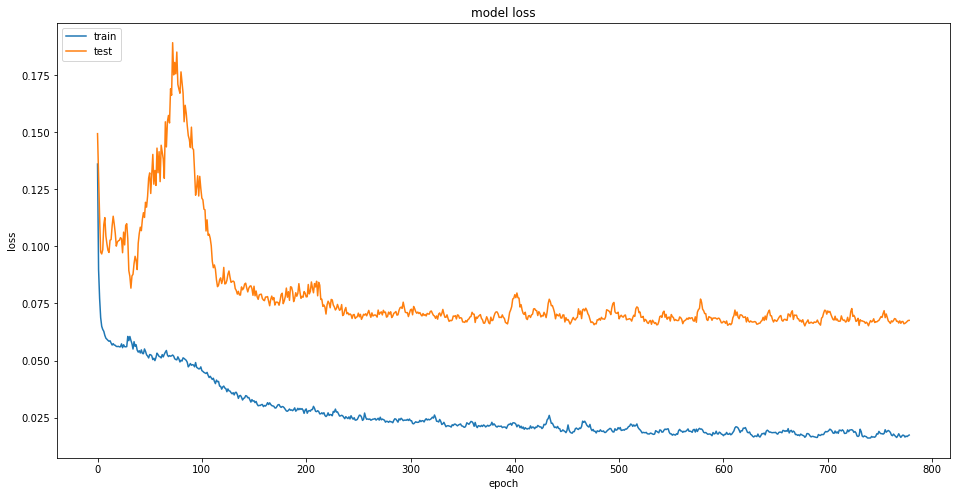

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8)) 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('PV_Tl1h_TrainingandValidation Loss.png')
plt.show()

#print(get_flops(model))

In [9]:
trainPredict = model.predict(trX, batch_size=batch_size)
validPredict = model.predict(vaX, batch_size=batch_size)
testPredict = model.predict(teX, batch_size=batch_size)

In [10]:
tePredict = testPredict.reshape([-1])
testY = teY.reshape([-1])

np.savetxt('PV_Tl1h_testPredict.txt', tePredict)
 
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(testY-tePredict))), ' MAE == ', mean_absolute_error(testY, tePredict))

Error Test Score > RMSE ==  0.06695711185043882  MAE ==  0.0351763353121748


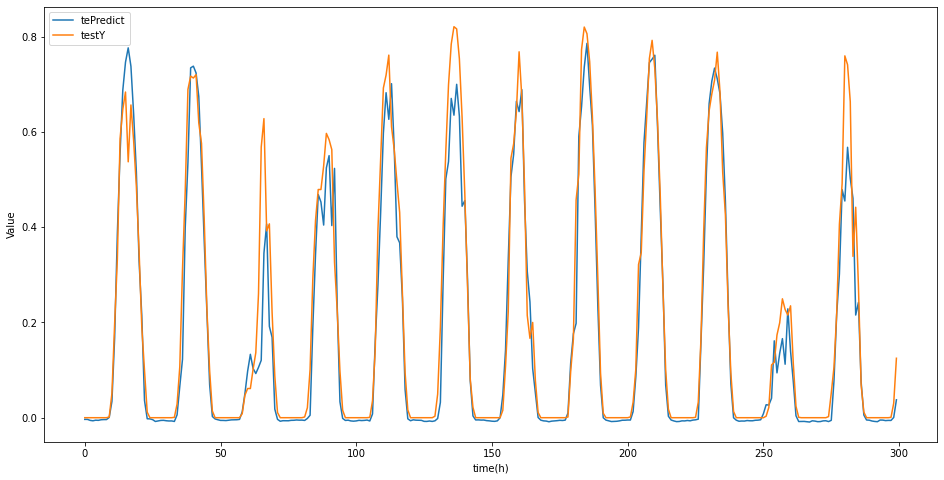

In [11]:
plt.figure(figsize=(16,8)) 
plt.plot(tePredict[0:300])
plt.plot(testY[0:300])
plt.ylabel('Value')
plt.xlabel('time(h)')
plt.legend(['tePredict', 'testY'], loc='upper left')
plt.show()

In [12]:
e_tr = trainPredict - trY
e_va = validPredict - vaY
errors = np.vstack([e_tr,e_va])
prediction = np.vstack([trainPredict,validPredict])
print(errors.shape)
print(prediction.shape)

(21470, 1)
(21470, 1)


In [14]:
layer_outputs = [layer.output for layer in model.layers if layer.name=='attention_vec']
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
attention_vectors = []
output_data = activation_model.predict(teX, batch_size=batch_size)
output_data = np.array(output_data)
print(output_data.shape)
at_vec = np.mean(output_data, axis=0)
print(at_vec, at_vec.shape)
np.savetxt('Attention_Basic.txt', at_vec)
at_vec = abs(at_vec)

C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(9146, 30, 13)
[[ 1.34494249e-02  3.94575438e-03  5.20631932e-02  2.55067311e-02
   2.24080728e-03  3.16566031e-04  1.79050583e-02  3.95707460e-03
   1.13539286e-02  1.48073016e-02  5.20736612e-02  5.36317378e-03
   1.46518359e-02]
 [ 1.49481833e-01  1.62003674e-02  2.18593568e-01  1.16979435e-01
   1.32649885e-02  1.68050360e-03  7.55868405e-02  1.66709851e-02
   1.09720297e-01  1.49543077e-01  2.18189895e-01  3.55383083e-02
   6.51493594e-02]
 [-6.97065741e-02 -1.44240782e-02  1.73447102e-01 -1.55229568e-02
  -1.37967002e-02 -3.52925225e-03 -9.70184244e-03 -1.29868481e-02
  -3.86037305e-02 -6.43585026e-02  1.82140529e-01 -2.56510568e-03
  -2.34361403e-02]
 [ 2.32336260e-02 -4.32260260e-02  6.91333190e-02  9.49051697e-03
  -4.22953404e-02 -5.61749786e-02 -1.31119853e-02 -4.32692617e-02
   7.63405859e-03  2.32539065e-02  7.08470047e-02 -2.96128951e-02
  -1.39774745e-02]
 [ 2.23963149e-02  5.80246095e-03  4.27725278e-02  2.10554339e-02
   6.06088154e-03  1.35007640e-03  1.49095673e-02  

In [16]:
import shap
shap.initjs()
background = trX[np.random.choice(trX.shape[0], 300, replace=False)]
print(background.shape)
explainer = shap.DeepExplainer(model, background)
test_sample = trX[-100:]
shap_values = explainer.shap_values(background)

(300, 30, 13)



In [17]:
shap_np = np.array(shap_values[0])
shap_np = shap_np.reshape(-1,num_features)
print("=========================================================================")
print(shap_np)
np.savetxt('SHAP_VALUES_basic.txt', shap_np)

[[-8.73329946e-03  2.85988677e-04 -4.32988904e-06 ...  3.12457322e-05
  -5.74465521e-04 -3.06313436e-05]
 [-1.89041379e-03  2.69749587e-05  3.61737170e-07 ...  1.06118861e-04
  -4.11552318e-04 -4.10724880e-04]
 [ 7.59440876e-03 -3.59104228e-04 -1.15552538e-06 ...  7.86836101e-05
   1.15892823e-04 -8.11059327e-04]
 ...
 [ 7.31476792e-03 -3.57210910e-05  1.83711157e-05 ...  2.97135432e-05
  -1.16325308e-03 -3.04598486e-04]
 [-2.55671815e-02 -4.30058827e-04 -2.17279226e-06 ...  4.64557063e-05
  -1.94280302e-03 -1.95252888e-04]
 [-9.52741385e-02 -1.76140448e-03  1.95539251e-04 ...  6.19157961e-04
  -8.13134213e-03  5.54596206e-04]]


In [76]:
e_tr = trainPredict - trY
e_va = validPredict - vaY
errors = np.vstack([e_tr,e_va])
prediction = np.vstack([trainPredict,validPredict])
print(errors.shape)
print(prediction.shape)

(21470, 1)
(21470, 1)


In [77]:
dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df2 = norm_df.iloc[:21447, :].copy()
norm_df2.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [78]:
Prindex = ['Prediction1']
Erindex = ['Error1']

pr_df = pd.DataFrame(prediction, columns=Prindex)
pr_df.head()

,Prediction1
0,-0.000146
1,-0.001398
2,0.036690
3,0.118622
4,0.466625


In [79]:
er_df = pd.DataFrame(errors, columns=Erindex)
er_df.head()

,Error1
0,-0.000146
1,-0.001398
2,0.008783
3,-0.038742
4,-0.034926


In [80]:
norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C,Prediction1,Error1
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834,-0.000146,-0.000146
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479,-0.001398,-0.001398
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152,0.036690,0.008783
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989,0.118622,-0.038742
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825,0.466625,-0.034926


Saving heatmap


<Figure size 432x288 with 0 Axes>

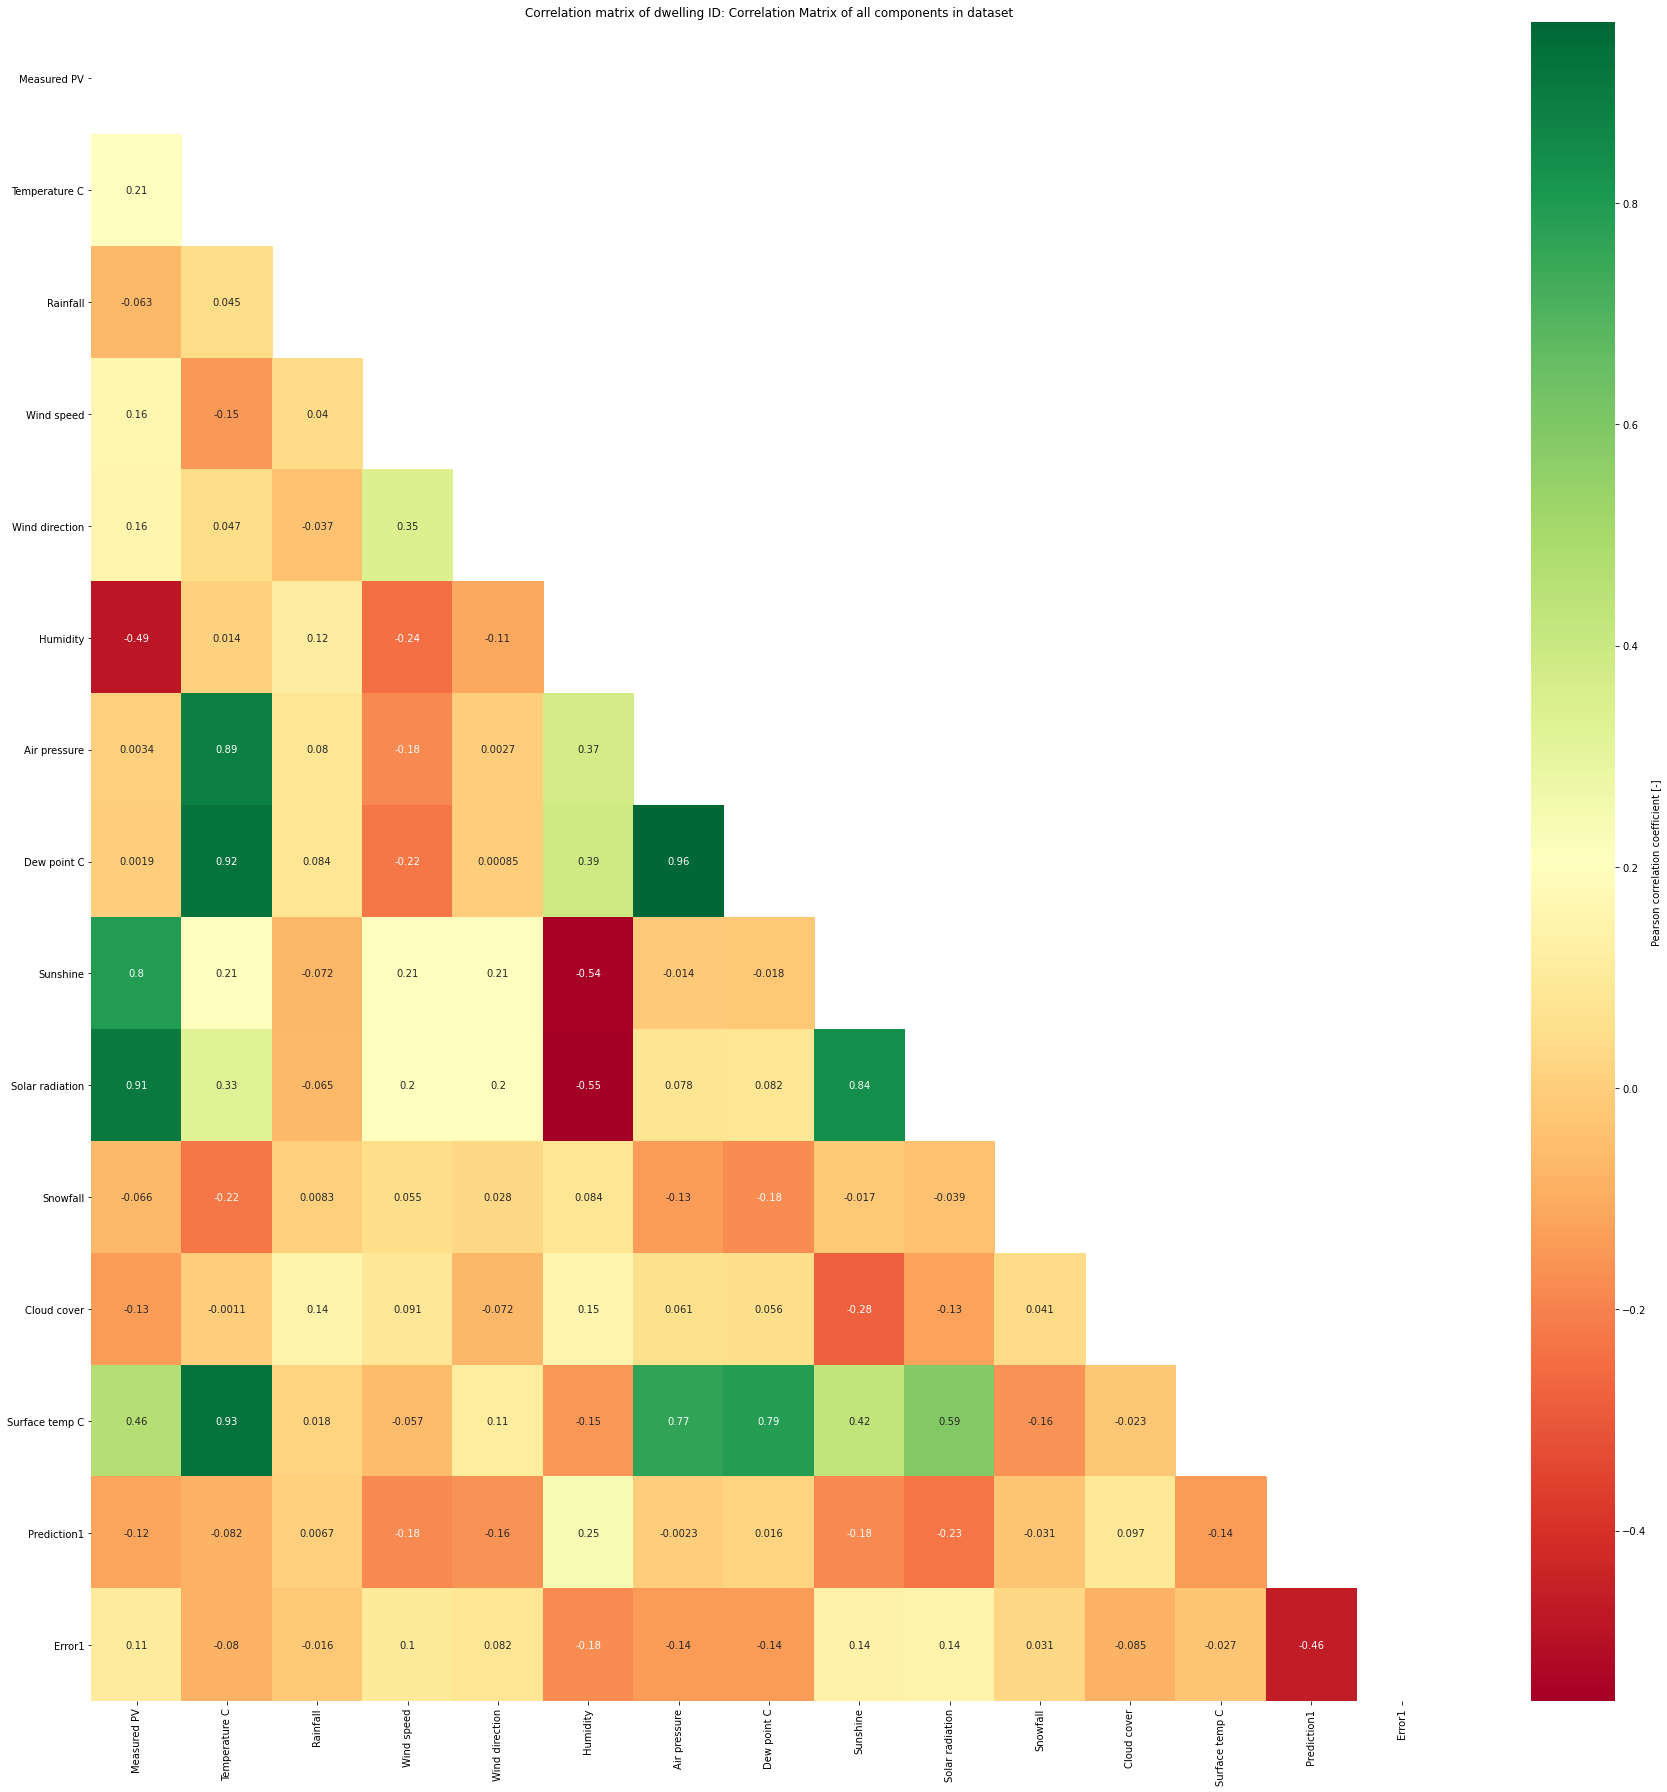

In [82]:
import seaborn as sns
from keijzer import *

fig = create_corr_matrix(norm_df2, 'Correlation Matrix of all components in dataset', True, size=(25,25))
fig.savefig('correlation_matrix.png')

In [32]:
norm_df2 = np.array(norm_df2)
print(norm_df2.shape)
timesteps = 30
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
print(Xe.shape)
print(Ye.shape)

(21470, 15)
(21438, 30, 15)
(21438, 1, 15)


In [41]:
trXe = Xe[:19000, :, :]
vaXe = Xe[19000:, :, :]
trYe = Ye[:19000, :, -1:]
vaYe = Ye[19000:, :, -1:]
trYe = trYe.reshape(-1,1)
vaYe = vaYe.reshape(-1,1)
print(trXe.shape)
print(trYe.shape)
print(vaXe.shape)

(19000, 30, 15)
(19000, 1)
(2438, 30, 15)


In [42]:
with tf.device('/gpu:0'):
    alpha=1.0
    gamma=1.2
    beta = 1.178511
    num_features = 15
    hfilters = 256
    hkernel_size1 = 2
    hkernel_size2 = 4
    visible1e = Input(shape=(timesteps, num_features))
    per1 = Permute((2,1))(visible1e)
    den1a = Dense(timesteps, activation='tanh')(per1)
    den1b = Dense(timesteps, activation='sigmoid')(per1)
    den1 = Multiply()([den1a, den1b])
    per2 = Permute((2,1), name='attention_vece')(den1)
    mul1 = Multiply()([visible1e, per2])
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(mul1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1e])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    
    res10 = Add()([d1, res09])   # 
    
    print('res10 :', res10.shape)  # (None, 24, 11) 
    
    oute = Conv1D(512, 1, padding='same', activation='relu')(res10)   # 256, 11X10=110  
    oute = Dropout(0.2)(oute)   
    
    oute = Conv1D(256, 1, padding='same', activation='relu')(oute) # 512,  110X5=550
    oute = Dropout(0.2)(oute)  
    
    oute = GlobalAveragePooling1D()(oute) # pool_size=2, strides=1
    
    oute = Dense(1)(oute) 
    modele = Model(inputs=[visible1e], outputs=[oute])
    
    print(modele.summary())
    
    modele.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae', 'mape'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=100)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()
    
    #hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

res10 : (?, 30, 15)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30, 15)]     0                                            
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 15, 30)       0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 15, 30)       930         permute_3[0][0]                  
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 15, 30)       930         permute_3[0][0]                  
________________________________________________________________________

In [43]:
    %%time
    histe = modele.fit(trXe, trYe, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaXe, vaYe), callbacks=[history, early_stopping])  # , checkpoint

Train on 19000 samples, validate on 2438 samples
Epoch 1/1000
19000/19000 [==============================] - ETA: 0s - loss: 0.0255 - root_mean_squared_error: 0.0255 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0188 - mean_absolute_percentage_error: 3223.1536

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


19000/19000 [==============================] - 7s 357us/sample - loss: 0.0255 - root_mean_squared_error: 0.0255 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0188 - mean_absolute_percentage_error: 3223.1536 - val_loss: 0.0667 - val_root_mean_squared_error: 0.0668 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0359 - val_mean_absolute_percentage_error: 772.0824
Epoch 2/1000
19000/19000 [==============================] - 6s 311us/sample - loss: 0.0195 - root_mean_squared_error: 0.0195 - mean_squared_error: 4.5904e-04 - mean_absolute_error: 0.0128 - mean_absolute_percentage_error: 1158.2156 - val_loss: 0.0664 - val_root_mean_squared_error: 0.0668 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0350 - val_mean_absolute_percentage_error: 449.9210
Epoch 3/1000
19000/19000 [==============================] - 6s 313us/sample - loss: 0.0185 - root_mean_squared_error: 0.0185 - mean_squared_error: 4.2249e-04 - mean_absolute_error: 0.0116 - mean_absolute_percent

In [62]:
dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df2 = norm_df.iloc[21470:, :]
eteX, eteY = create_dataset(np.array(norm_df2), timesteps, 1)

print(eteX.shape)
print(eteY.shape)
print(tePredict.reshape(-1,1).shape)

npnorm2 =np.array(norm_df2)
print(npnorm2.shape)
npnorm2 = npnorm2[30:-2,:]


(9146, 30, 13)
(9146, 1, 13)
(9146, 1)
(9178, 13)


In [63]:
pr_df = pd.DataFrame(tePredict.reshape(-1,1), columns=Prindex)
pr_df.head()

,Prediction1
0,-0.003524
1,-0.003545
2,-0.005656
3,-0.006481
4,-0.005237


In [64]:
teY = testY.reshape(-1,1)
e_te = testPredict-teY
er_df = pd.DataFrame(e_te, columns=Erindex)
er_df.head()

,Error1
0,-0.003524
1,-0.003545
2,-0.005656
3,-0.006481
4,-0.005237


In [65]:
prnorm = np.array(pr_df)
ernorm =np.array(er_df)
print(ernorm.shape)

(9146, 1)


In [66]:
etedat = np.concatenate((npnorm2, prnorm, ernorm), axis=1)
print(etedat.shape)

(9146, 15)


In [67]:
eteX, eteY = create_dataset(etedat, timesteps, output_timesteps)
eteY = eteY[:,:,-1:].reshape(-1,1)
print(eteX.shape)
print(eteY.shape)

(9114, 30, 15)
(9114, 1)


In [68]:
etePredict = modele.predict(eteX, batch_size=batch_size)
print(etePredict.shape)
print(etePredict)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


(9114, 1)
[[-1.12768386e-04]
 [-1.12768386e-04]
 [ 6.62858874e-05]
 ...
 [-1.12768386e-04]
 [-6.89518172e-04]
 [-1.12768386e-04]]


In [69]:
testPredict = tePredict.reshape(-1,1)
addtestPredict = -etePredict + testPredict[30:-2,:]
print(addtestPredict.shape)

(9114, 1)


In [70]:
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(teY[30:-2,:]-testPredict[30:-2,:]))), ' MAE == ', mean_absolute_error(teY[30:-2,:], testPredict[30:-2,:]))
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(teY[30:-2,:]-addtestPredict))), ' MAE == ', mean_absolute_error(teY[30:-2,:], addtestPredict))

Error Test Score > RMSE ==  0.06700560130722082  MAE ==  0.03520625591287073
Error Test Score > RMSE ==  0.06465500333981196  MAE ==  0.033808353467311286


In [71]:
np.savetxt('FSEFF_FSEFFEL_FinaltestPredict.txt', addtestPredict)

In [72]:
layer_outputs = [layer.output for layer in modele.layers if layer.name=='attention_vece']
activation_model = tf.keras.models.Model(inputs=modele.input, outputs=layer_outputs)
attention_vectors = []
output_data = activation_model.predict(eteX, batch_size=batch_size)
output_data = np.array(output_data)
print(output_data.shape)
at_vec = np.mean(output_data, axis=0)
print(at_vec, at_vec.shape)
np.savetxt('Attention_FSEFF_FSEFFEL.txt', at_vec)
at_vec = abs(at_vec)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


(9114, 30, 15)
[[ 9.05390009e-02  2.87507661e-02  9.53909382e-02  7.44203627e-02
   2.65888236e-02  1.07758148e-02  5.53056188e-02  2.72518415e-02
   8.11954662e-02  9.01417658e-02  9.54507366e-02  2.71957461e-02
   5.74599318e-02  9.16830078e-02  9.46561694e-02]
 [ 1.56989470e-02 -4.03762423e-03  3.53087112e-02  1.21300695e-02
  -6.90362649e-03 -7.54377618e-03  5.42187411e-03 -4.05395078e-03
   9.65288468e-03  1.66590288e-02  3.61289568e-02 -3.75571591e-03
   4.66568442e-03  1.66955218e-02  3.76532674e-02]
 [-1.04003754e-02 -4.52107401e-04 -5.82832620e-02 -1.00673279e-02
  -2.16961489e-04  2.11405095e-05 -6.54802052e-03 -6.05590991e-04
  -1.24829980e-02 -1.12682972e-02 -6.01707064e-02 -4.34349244e-03
  -4.29970445e-03 -1.16083957e-02 -6.75797686e-02]
 [-2.44181845e-02 -4.39444631e-02 -2.67762970e-03 -3.63044143e-02
  -4.22769524e-02 -3.88276950e-02 -3.96803804e-02 -4.27242815e-02
  -2.51276139e-02 -2.40156110e-02 -1.59637141e-03 -4.13487293e-02
  -4.21659797e-02 -2.33658217e-02  2.625

In [73]:
import shap
shap.initjs()
background = trXe[np.random.choice(trXe.shape[0], 300, replace=False)]
print(background.shape)
explainer = shap.DeepExplainer(modele, background)
test_sample = trXe[-100:]
shap_values = explainer.shap_values(background)

(300, 30, 15)


In [74]:
index2 = np.concatenate([index, Prindex, Erindex])

In [75]:
shap_np = np.array(shap_values[0])
shap_np = shap_np.reshape(-1,num_features)
print("=========================================================================")
print(shap_np)
np.savetxt('SHAP_VALUES_FSEFF_FSEFFEL.txt', shap_np)

[[-3.82059645e-06  2.63002186e-05  4.03244910e-07 ...  1.35140286e-04
  -1.42756121e-03  8.31415242e-05]
 [-2.11029186e-06  9.29506945e-05 -3.49240652e-06 ...  8.83708136e-05
  -8.24431051e-04  1.50827298e-05]
 [ 3.57079010e-06  6.21752709e-05 -1.26871177e-06 ...  8.68710400e-05
  -1.06477648e-03  2.42393392e-05]
 ...
 [ 7.68660577e-05 -2.30086081e-05 -7.07870443e-08 ... -4.63101469e-08
  -9.29220923e-05 -7.63364696e-06]
 [-7.36330811e-05 -8.25589150e-05  7.72330974e-07 ... -2.96135605e-06
   4.86407806e-04  4.56224784e-04]
 [-1.05038481e-05 -1.10523831e-04 -4.38197979e-06 ... -2.31192929e-05
   1.87589665e-03  6.81273142e-04]]
